<a href="https://colab.research.google.com/github/nakyung55/FintechAI/blob/main/1_%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1%EA%B3%BC%ED%8A%9C%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **주택가격예측과튜닝**


Dataset : The Ames Housing dataset (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)



*  데이터는 1460건이며, 총 81개 컬럼으로 구성됨
*  SalesPrice 컬럼이 예측해야하는 주택가격임



In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle

!pip install optuna
import optuna

google_path = 'https://drive.google.com/uc?id='
file_id = '1oL3KU8zMxI8AfANJSeI-jHCQHZeiJ9mW'
output_name = 'train.csv'
gdown.download(google_path+file_id, output_name)

train = pd.read_csv('train.csv')

# 수치형 컬럼만 추출
numeric_cols = train.select_dtypes(include=[np.number])

# SalePrice와 상관계수 계산
corr = numeric_cols.corr()['SalePrice'].abs().sort_values(ascending=False)

# 상위 6개 + SalePrice
top6 = corr.index[1:7]   # SalePrice 제외
use_cols = list(top6) + ['SalePrice']
train = train[use_cols]

# 결측치 평균으로 치환
train_fillna = train.fillna(train.mean())

# 7:3 비율로 분리
train_data = train_fillna[:1022]
valid_data = train_fillna[1022:]

x_train = train_data.iloc[:, :6]
y_train = train_data.iloc[:, -1]
x_valid = valid_data.iloc[:, :6]
y_valid = valid_data.iloc[:, -1]

# 학습
params = {
    'n_estimators': 800,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'objective': 'regression',
    'objective': 'rmse',
    'random_state': 42,
}

model = lgb.LGBMRegressor(**params)
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])

# 예측
valid_data = valid_data.copy()
valid_data['pred'] = model.predict(x_valid)

# 검증
score = np.sqrt(mean_squared_error(y_valid, valid_data['pred']))
print('RMSE = ', score)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.8 MB/s eta 0:00:00


Downloading...
From: https://drive.google.com/uc?id=1oL3KU8zMxI8AfANJSeI-jHCQHZeiJ9mW
To: /content/train.csv
100%|██████████| 461k/461k [00:00<00:00, 84.0MB/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 6
[LightGBM] [Info] Start training from score 181713.254403
RMSE =  35465.45355746323


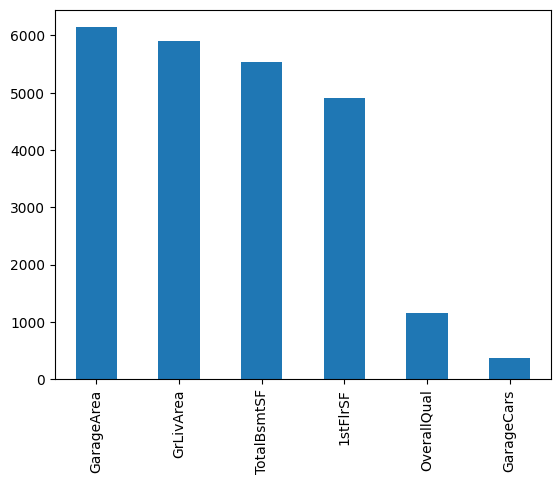

RMSE =  35465.45355746323


In [ ]:
# 변수 중요도
val_imp = pd.DataFrame(
    model.feature_importances_,
    index=model.feature_name_,
    columns=['imp']
)

# 변수 중요도 시각화
val_imp = val_imp.sort_values('imp', ascending=False)
val_imp['imp'].plot(kind='bar')
plt.show()

save_object = [model, params, valid_data]

# 저장
with open(file='my_model.pickle', mode='wb') as f:
    pickle.dump(save_object, f)

# 저장된 객체 불러오기
with open(file='my_model.pickle', mode='rb') as f:
    load_object = pickle.load(f)

# 저장된 객체 분리
model = load_object[0]
params = load_object[1]
valid_data = load_object[2]

# 예측
valid_data['pred'] = model.predict(x_valid)

# 검증
score = np.sqrt(mean_squared_error(y_valid, valid_data['pred']))
print('RMSE = ', score)

In [ ]:
# 튜닝 객체 생성
def model_tuner(trial, train_data, train_target, valid_data, valid_target):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)

    model.fit(
        train_data,
        train_target,
        eval_set=[(valid_data, valid_target)],
        eval_metric='rmse',
         callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(0)
         ]
    )

    y_preds = model.predict(valid_data)
    score = np.sqrt(mean_squared_error(valid_target, y_preds))

    return score

In [ ]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=42),
    direction='minimize'
)

study.optimize(
    lambda trial: model_tuner(trial, x_train, y_train, x_valid, y_valid),
    n_trials=100
)

print('최적 파라메터 : ', study.best_trial.params)

best_params = study.best_trial.params

best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42
})

# 최적 모델 생성
model = lgb.LGBMRegressor(**best_params)

model.fit(
    x_train,
    y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(0)
    ]
)
model

# 검증
y_preds = model.predict(x_valid)
score = np.sqrt(mean_squared_error(y_valid, y_preds))
print('RMSE = ', score)

[I 2026-02-19 03:17:17,394] A new study created in memory with name: no-name-72fdf857-95d3-4909-a4cd-7bd6fb013346
[I 2026-02-19 03:17:17,474] Trial 0 finished with value: 34585.658356291206 and parameters: {'n_estimators': 4371, 'learning_rate': 0.1540359659501924, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797}. Best is trial 0 with value: 34585.658356291206.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 34585.7
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:17,802] Trial 1 finished with value: 35676.58391659859 and parameters: {'n_estimators': 8796, 'learning_rate': 0.02416482602989751, 'num_leaves': 112, 'max_depth': 3, 'min_child_samples': 49, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105}. Best is trial 0 with value: 34585.658356291206.


Early stopping, best iteration is:
[1725]	valid_0's rmse: 35676.6
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2636]	valid_0's rmse: 34828


[I 2026-02-19 03:17:20,343] Trial 2 finished with value: 34827.97116958118 and parameters: {'n_estimators': 2636, 'learning_rate': 0.002642526057549917, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518}. Best is trial 0 with value: 34585.658356291206.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2255]	valid_0's rmse: 35509.5


[I 2026-02-19 03:17:22,367] Trial 3 finished with value: 35509.53025336709 and parameters: {'n_estimators': 2255, 'learning_rate': 0.0047014692435609715, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446}. Best is trial 0 with value: 34585.658356291206.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3108]	valid_0's rmse: 33687.6


[I 2026-02-19 03:17:28,297] Trial 4 finished with value: 33687.62043374037 and parameters: {'n_estimators': 6332, 'learning_rate': 0.0012790390175145834, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9795542149013333, 'colsample_bytree': 0.9862528132298237}. Best is trial 4 with value: 33687.62043374037.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1488]	valid_0's rmse: 35000.9


[I 2026-02-19 03:17:31,231] Trial 5 finished with value: 35000.931267628555 and parameters: {'n_estimators': 8276, 'learning_rate': 0.0050225633119947675, 'num_leaves': 32, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508}. Best is trial 4 with value: 33687.62043374037.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 34637.6


[I 2026-02-19 03:17:31,471] Trial 6 finished with value: 34637.64097651767 and parameters: {'n_estimators': 1309, 'learning_rate': 0.12370108840299013, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.8080272084711243, 'colsample_bytree': 0.8186841117373118}. Best is trial 4 with value: 33687.62043374037.


Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:31,991] Trial 7 finished with value: 34623.16175796802 and parameters: {'n_estimators': 2663, 'learning_rate': 0.17023282716867383, 'num_leaves': 121, 'max_depth': 15, 'min_child_samples': 46, 'subsample': 0.8391599915244341, 'colsample_bytree': 0.9687496940092467}. Best is trial 4 with value: 33687.62043374037.


Early stopping, best iteration is:
[207]	valid_0's rmse: 34623.2
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1796]	valid_0's rmse: 34689.2


[I 2026-02-19 03:17:34,594] Trial 8 finished with value: 34689.174721769385 and parameters: {'n_estimators': 1796, 'learning_rate': 0.0028246357083904893, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7085396127095583, 'colsample_bytree': 0.9314950036607718}. Best is trial 4 with value: 33687.62043374037.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[4211]	valid_0's rmse: 34617.5


[I 2026-02-19 03:17:37,511] Trial 9 finished with value: 34617.518940471964 and parameters: {'n_estimators': 4211, 'learning_rate': 0.004430357105538922, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 41, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069}. Best is trial 4 with value: 33687.62043374037.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4157]	valid_0's rmse: 33270.7


[I 2026-02-19 03:17:42,769] Trial 10 finished with value: 33270.65980729153 and parameters: {'n_estimators': 6748, 'learning_rate': 0.0010322851929145003, 'num_leaves': 147, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9630659181130071, 'colsample_bytree': 0.8921467580828039}. Best is trial 10 with value: 33270.65980729153.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3864]	valid_0's rmse: 33185


[I 2026-02-19 03:17:44,917] Trial 11 finished with value: 33185.02496715276 and parameters: {'n_estimators': 6742, 'learning_rate': 0.0011993262859716955, 'num_leaves': 150, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9814494294630898, 'colsample_bytree': 0.8899883294469093}. Best is trial 11 with value: 33185.02496715276.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3823]	valid_0's rmse: 33864.2


[I 2026-02-19 03:17:48,059] Trial 12 finished with value: 33864.227635711795 and parameters: {'n_estimators': 6971, 'learning_rate': 0.0011118066758324997, 'num_leaves': 150, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9035051710026214, 'colsample_bytree': 0.8927299818207691}. Best is trial 11 with value: 33185.02496715276.
[I 2026-02-19 03:17:48,174] Trial 13 finished with value: 34902.18422144645 and parameters: {'n_estimators': 9970, 'learning_rate': 0.012660443600759791, 'num_leaves': 145, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.9967819100045477, 'colsample_bytree': 0.8847911208853647}. Best is trial 11 with value: 33185.02496715276.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid_0's rmse: 34902.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5029]	valid_0's rmse: 35423


[I 2026-02-19 03:17:50,269] Trial 14 finished with value: 35423.02699200654 and parameters: {'n_estimators': 5598, 'learning_rate': 0.0010083941724461742, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.8887838797645187, 'colsample_bytree': 0.7454256672970064}. Best is trial 11 with value: 33185.02496715276.


Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:50,915] Trial 15 finished with value: 33462.60731315257 and parameters: {'n_estimators': 7585, 'learning_rate': 0.014583189884321252, 'num_leaves': 133, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.947890255035807, 'colsample_bytree': 0.9006453699263156}. Best is trial 11 with value: 33185.02496715276.


Early stopping, best iteration is:
[682]	valid_0's rmse: 33462.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3355]	valid_0's rmse: 35209.5


[I 2026-02-19 03:17:52,035] Trial 16 finished with value: 35209.46023305263 and parameters: {'n_estimators': 4737, 'learning_rate': 0.0018972146003137682, 'num_leaves': 130, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.8601329035339931, 'colsample_bytree': 0.7495910822966338}. Best is trial 11 with value: 33185.02496715276.


Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:52,369] Trial 17 finished with value: 32748.320603846827 and parameters: {'n_estimators': 6182, 'learning_rate': 0.04111012746987728, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7624141988568561, 'colsample_bytree': 0.9311149037830164}. Best is trial 17 with value: 32748.320603846827.
[I 2026-02-19 03:17:52,481] Trial 18 finished with value: 34610.98568039515 and parameters: {'n_estimators': 5533, 'learning_rate': 0.06896234003560581, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7588434967762665, 'colsample_bytree': 0.939289691972804}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[538]	valid_0's rmse: 32748.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's rmse: 34611


[I 2026-02-19 03:17:52,612] Trial 19 finished with value: 34429.25843893924 and parameters: {'n_estimators': 3522, 'learning_rate': 0.05097961439036534, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7719877891554076, 'colsample_bytree': 0.8509679306459871}. Best is trial 17 with value: 32748.320603846827.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 34429.3
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:53,015] Trial 20 finished with value: 34303.008600131405 and parameters: {'n_estimators': 7863, 'learning_rate': 0.03503776504888307, 'num_leaves': 98, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.601404760706113, 'colsample_bytree': 0.9404562064907379}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[208]	valid_0's rmse: 34303
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:53,475] Trial 21 finished with value: 33159.53448054359 and parameters: {'n_estimators': 6431, 'learning_rate': 0.01008522741244664, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9495632153661151, 'colsample_bytree': 0.869338681861774}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[471]	valid_0's rmse: 33159.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:53,787] Trial 22 finished with value: 34591.730787652356 and parameters: {'n_estimators': 6315, 'learning_rate': 0.00878879829067873, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9040368390630549, 'colsample_bytree': 0.8571490596211431}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[419]	valid_0's rmse: 34591.7
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:54,068] Trial 23 finished with value: 34948.62930475389 and parameters: {'n_estimators': 5740, 'learning_rate': 0.02431191421104112, 'num_leaves': 69, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8049119701904306, 'colsample_bytree': 0.9197942239143678}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[315]	valid_0's rmse: 34948.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:54,505] Trial 24 finished with value: 33171.8085008907 and parameters: {'n_estimators': 7286, 'learning_rate': 0.06078879350021284, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9310432350151344, 'colsample_bytree': 0.784515038924432}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[355]	valid_0's rmse: 33171.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:54,703] Trial 25 finished with value: 34892.808618899224 and parameters: {'n_estimators': 9231, 'learning_rate': 0.07316597065054674, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7551316120388607, 'colsample_bytree': 0.7820882622662062}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[149]	valid_0's rmse: 34892.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:55,051] Trial 26 finished with value: 33243.610995380994 and parameters: {'n_estimators': 7248, 'learning_rate': 0.09596600874351205, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8489527798563447, 'colsample_bytree': 0.742841143535453}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[266]	valid_0's rmse: 33243.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:55,262] Trial 27 finished with value: 34443.612656686666 and parameters: {'n_estimators': 4916, 'learning_rate': 0.03802386527360697, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9259308962023542, 'colsample_bytree': 0.6974040046404777}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[103]	valid_0's rmse: 34443.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:55,744] Trial 28 finished with value: 34876.069272030094 and parameters: {'n_estimators': 6147, 'learning_rate': 0.021045987827182745, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 31, 'subsample': 0.8759969240337222, 'colsample_bytree': 0.8584664332413804}. Best is trial 17 with value: 32748.320603846827.


Early stopping, best iteration is:
[828]	valid_0's rmse: 34876.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[912]	valid_0's rmse: 34018.2


[I 2026-02-19 03:17:56,483] Trial 29 finished with value: 34018.22811794431 and parameters: {'n_estimators': 8195, 'learning_rate': 0.008232996064679822, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.827774964031719, 'colsample_bytree': 0.6813610836660217}. Best is trial 17 with value: 32748.320603846827.
[I 2026-02-19 03:17:56,660] Trial 30 finished with value: 33646.62071246258 and parameters: {'n_estimators': 3820, 'learning_rate': 0.03454387063516682, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7345628216334097, 'colsample_bytree': 0.6088017347852452}. Best is trial 17 with value: 32748.320603846827.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's rmse: 33646.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:56,762] Trial 31 finished with value: 33648.64531397352 and parameters: {'n_estimators': 6784, 'learning_rate': 0.05385208214793973, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9941391651500752, 'colsample_bytree': 0.8284665865254732}. Best is trial 17 with value: 32748.320603846827.
[I 2026-02-19 03:17:56,841] Trial 32 finished with value: 32246.515591137195 and parameters: {'n_estimators': 5060, 'learning_rate': 0.12526088453984055, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.934262207763238, 'colsample_bytree': 0.9588237266614188}. Best is trial 32 with value: 32246.515591137195.
[I 2026-02-19 03:17:56,946] Trial 33 finished with value: 33370.302144465444 and parameters: {'n_estimators': 5221, 'learning_rate': 0.09923950997919082, 'num_leaves': 102, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9269894586470143, 'colsample_bytree': 0.9669648149787122}. Best is trial 32 with value: 32246.51559113

Early stopping, best iteration is:
[92]	valid_0's rmse: 33648.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 32246.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's rmse: 33370.3


[I 2026-02-19 03:17:57,034] Trial 34 finished with value: 33570.49258129517 and parameters: {'n_estimators': 5995, 'learning_rate': 0.18769142560697702, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.9520882873554657, 'colsample_bytree': 0.9603237224755768}. Best is trial 32 with value: 32246.515591137195.
[I 2026-02-19 03:17:57,138] Trial 35 finished with value: 35050.57748461222 and parameters: {'n_estimators': 4736, 'learning_rate': 0.13292178868839527, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9202915332977188, 'colsample_bytree': 0.7658969690431807}. Best is trial 32 with value: 32246.515591137195.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's rmse: 33570.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 35050.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:17:57,453] Trial 36 finished with value: 34496.99820309588 and parameters: {'n_estimators': 8955, 'learning_rate': 0.020773548103928414, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.954369640524367, 'colsample_bytree': 0.9190767930325219}. Best is trial 32 with value: 32246.515591137195.
[I 2026-02-19 03:17:57,569] Trial 37 finished with value: 34517.807822646646 and parameters: {'n_estimators': 7595, 'learning_rate': 0.0885096821110023, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7887635378190354, 'colsample_bytree': 0.8726268238574298}. Best is trial 32 with value: 32246.515591137195.


Early stopping, best iteration is:
[153]	valid_0's rmse: 34497
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's rmse: 34517.8


[I 2026-02-19 03:17:57,636] Trial 38 finished with value: 35018.965191704265 and parameters: {'n_estimators': 4267, 'learning_rate': 0.05109788701438836, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.8725443644151719, 'colsample_bytree': 0.8291486826365813}. Best is trial 32 with value: 32246.515591137195.
[I 2026-02-19 03:17:57,748] Trial 39 finished with value: 33817.03006872489 and parameters: {'n_estimators': 3349, 'learning_rate': 0.13307644322931533, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6991663356638441, 'colsample_bytree': 0.7062972020367302}. Best is trial 32 with value: 32246.515591137195.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 35019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's rmse: 33817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3353]	valid_0's rmse: 34105.1


[I 2026-02-19 03:17:58,926] Trial 40 finished with value: 34105.051832234174 and parameters: {'n_estimators': 8216, 'learning_rate': 0.0071311535785099365, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.8233724004312745, 'colsample_bytree': 0.8010135282692322}. Best is trial 32 with value: 32246.515591137195.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1724]	valid_0's rmse: 33431.7


[I 2026-02-19 03:17:59,920] Trial 41 finished with value: 33431.684876997155 and parameters: {'n_estimators': 6504, 'learning_rate': 0.0025175977712092973, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.974994441318965, 'colsample_bytree': 0.9072988320968841}. Best is trial 32 with value: 32246.515591137195.
[I 2026-02-19 03:18:00,053] Trial 42 finished with value: 32897.39740772957 and parameters: {'n_estimators': 7101, 'learning_rate': 0.027870853502745582, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.9676272424936649, 'colsample_bytree': 0.9523831021461778}. Best is trial 32 with value: 32246.515591137195.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's rmse: 32897.4
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:00,188] Trial 43 finished with value: 33788.752840569585 and parameters: {'n_estimators': 7437, 'learning_rate': 0.027261478495455984, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9365638684387193, 'colsample_bytree': 0.9900295857602459}. Best is trial 32 with value: 32246.515591137195.


Early stopping, best iteration is:
[304]	valid_0's rmse: 33788.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:00,755] Trial 44 finished with value: 35410.14345214743 and parameters: {'n_estimators': 6998, 'learning_rate': 0.014265405766251495, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 50, 'subsample': 0.9052559310060408, 'colsample_bytree': 0.953126705478031}. Best is trial 32 with value: 32246.515591137195.


Early stopping, best iteration is:
[1798]	valid_0's rmse: 35410.1
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:00,893] Trial 45 finished with value: 31959.723666305934 and parameters: {'n_estimators': 6084, 'learning_rate': 0.06446224681891118, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.96518898108903, 'colsample_bytree': 0.9709727361999646}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:01,037] Trial 46 finished with value: 32565.038979267356 and parameters: {'n_estimators': 5185, 'learning_rate': 0.04244785211802252, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9683155112510613, 'colsample_bytree': 0.9789986538093263}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[382]	valid_0's rmse: 31959.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[538]	valid_0's rmse: 32565


[I 2026-02-19 03:18:01,139] Trial 47 finished with value: 35255.73947203265 and parameters: {'n_estimators': 5195, 'learning_rate': 0.042922881843636726, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.9723801347299801, 'colsample_bytree': 0.9792801144516938}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's rmse: 35255.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[506]	valid_0's rmse: 33951.7


[I 2026-02-19 03:18:01,296] Trial 48 finished with value: 33951.65790416648 and parameters: {'n_estimators': 5846, 'learning_rate': 0.0284140884489555, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9997015187611658, 'colsample_bytree': 0.9989784048089948}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:01,430] Trial 49 finished with value: 33822.49362951014 and parameters: {'n_estimators': 5340, 'learning_rate': 0.07809454771252727, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.6763072911491742, 'colsample_bytree': 0.9786254475583925}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[488]	valid_0's rmse: 33822.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:01,703] Trial 50 finished with value: 32804.22151388561 and parameters: {'n_estimators': 4510, 'learning_rate': 0.01747055884174506, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9787341693114209, 'colsample_bytree': 0.950103210819972}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[880]	valid_0's rmse: 32804.2
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:02,048] Trial 51 finished with value: 32600.957256741447 and parameters: {'n_estimators': 4478, 'learning_rate': 0.01914380217805672, 'num_leaves': 68, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9659943885116583, 'colsample_bytree': 0.9482150512804018}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[1063]	valid_0's rmse: 32601
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:02,251] Trial 52 finished with value: 33926.531280099945 and parameters: {'n_estimators': 3985, 'learning_rate': 0.016315423953192843, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.9839323704349892, 'colsample_bytree': 0.9300539769453727}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:02,364] Trial 53 finished with value: 34430.798661438435 and parameters: {'n_estimators': 2959, 'learning_rate': 0.018980464490049077, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9640160150363126, 'colsample_bytree': 0.9435103478373089}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[242]	valid_0's rmse: 33926.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 34430.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:02,444] Trial 54 finished with value: 34319.19031228138 and parameters: {'n_estimators': 4542, 'learning_rate': 0.04307653074095798, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9856365762898492, 'colsample_bytree': 0.9720123739444179}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[116]	valid_0's rmse: 34319.2
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:02,803] Trial 55 finished with value: 34298.45667385566 and parameters: {'n_estimators': 4917, 'learning_rate': 0.011234422412946497, 'num_leaves': 70, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9438436826759131, 'colsample_bytree': 0.9158602232854476}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:02,904] Trial 56 finished with value: 33958.83598675612 and parameters: {'n_estimators': 4482, 'learning_rate': 0.06593459894124849, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7298625870540486, 'colsample_bytree': 0.9994140115008886}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[920]	valid_0's rmse: 34298.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 33958.8


[I 2026-02-19 03:18:03,013] Trial 57 finished with value: 33372.38504466057 and parameters: {'n_estimators': 3887, 'learning_rate': 0.10407461740179548, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9119336230799246, 'colsample_bytree': 0.928744043278193}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's rmse: 33372.4
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:03,431] Trial 58 finished with value: 34268.26814866094 and parameters: {'n_estimators': 5014, 'learning_rate': 0.01740377340813745, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.7822707047410736, 'colsample_bytree': 0.9574747270172068}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:03,497] Trial 59 finished with value: 34203.660046471254 and parameters: {'n_estimators': 5598, 'learning_rate': 0.16255933898043667, 'num_leaves': 78, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8856262922795363, 'colsample_bytree': 0.9813648485939201}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[1505]	valid_0's rmse: 34268.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 34203.7
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:03,749] Trial 60 finished with value: 33869.34850695734 and parameters: {'n_estimators': 2017, 'learning_rate': 0.03231379587424737, 'num_leaves': 53, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.9574492242107093, 'colsample_bytree': 0.9466713565939611}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:03,832] Trial 61 finished with value: 33251.50854646759 and parameters: {'n_estimators': 5884, 'learning_rate': 0.04257093884660868, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9685105178371581, 'colsample_bytree': 0.9664350259653286}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[241]	valid_0's rmse: 33869.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 33251.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:04,050] Trial 62 finished with value: 32920.377328868 and parameters: {'n_estimators': 6285, 'learning_rate': 0.02281160551557704, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9385746973001514, 'colsample_bytree': 0.9381185056306208}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:04,141] Trial 63 finished with value: 34202.41237126935 and parameters: {'n_estimators': 5514, 'learning_rate': 0.029134694806527084, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9840928793491033, 'colsample_bytree': 0.9535255408247915}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[471]	valid_0's rmse: 32920.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's rmse: 34202.4
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:04,241] Trial 64 finished with value: 33590.197778674985 and parameters: {'n_estimators': 3534, 'learning_rate': 0.05768150308311765, 'num_leaves': 74, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9638510696300293, 'colsample_bytree': 0.8990718834248231}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:04,345] Trial 65 finished with value: 33898.0982812161 and parameters: {'n_estimators': 4138, 'learning_rate': 0.026160194043634028, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.9893002342242108, 'colsample_bytree': 0.9826504796273974}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[80]	valid_0's rmse: 33590.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's rmse: 33898.1
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:04,484] Trial 66 finished with value: 34072.06058307965 and parameters: {'n_estimators': 6613, 'learning_rate': 0.012578854955727265, 'num_leaves': 88, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9729934442584297, 'colsample_bytree': 0.9271752156790883}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:04,571] Trial 67 finished with value: 35380.109335052344 and parameters: {'n_estimators': 6072, 'learning_rate': 0.04701180259217447, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 35, 'subsample': 0.9410180339092988, 'colsample_bytree': 0.9062837646081278}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:04,635] Trial 68 finished with value: 33291.75907029442 and parameters: {'n_estimators': 4761, 'learning_rate': 0.11501186488102588, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9990229623812259, 'colsample_bytree': 0.9685508593561792}. Best is trial 45 with value: 31959.723666305

Early stopping, best iteration is:
[383]	valid_0's rmse: 34072.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 35380.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 33291.8


[I 2026-02-19 03:18:04,738] Trial 69 finished with value: 33880.54640306425 and parameters: {'n_estimators': 7891, 'learning_rate': 0.08160535706274301, 'num_leaves': 25, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9193317526716908, 'colsample_bytree': 0.8799252545003605}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 33880.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 34519.5


[I 2026-02-19 03:18:04,894] Trial 70 finished with value: 34519.495352064914 and parameters: {'n_estimators': 6984, 'learning_rate': 0.03435614391319527, 'num_leaves': 65, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.8939059176574496, 'colsample_bytree': 0.9511429343921284}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:05,116] Trial 71 finished with value: 33183.41979400655 and parameters: {'n_estimators': 6362, 'learning_rate': 0.022146619290911426, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9398347861596777, 'colsample_bytree': 0.940355459356977}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[533]	valid_0's rmse: 33183.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[822]	valid_0's rmse: 33047.7


[I 2026-02-19 03:18:05,391] Trial 72 finished with value: 33047.6675385269 and parameters: {'n_estimators': 5342, 'learning_rate': 0.02269826527770825, 'num_leaves': 39, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.754196975174797, 'colsample_bytree': 0.915394816397627}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:05,541] Trial 73 finished with value: 33968.97971991294 and parameters: {'n_estimators': 6224, 'learning_rate': 0.01659811128862556, 'num_leaves': 59, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9589411443324748, 'colsample_bytree': 0.9371862976356229}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's rmse: 33969
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:05,727] Trial 74 finished with value: 33992.82120562138 and parameters: {'n_estimators': 5081, 'learning_rate': 0.040013386826209585, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9488905416436395, 'colsample_bytree': 0.9637706334059277}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[220]	valid_0's rmse: 33992.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:06,134] Trial 75 finished with value: 34002.28011935349 and parameters: {'n_estimators': 4631, 'learning_rate': 0.019188570635182003, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9318214168936743, 'colsample_bytree': 0.9899545119542515}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[385]	valid_0's rmse: 34002.3
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:06,379] Trial 76 finished with value: 34000.69433753184 and parameters: {'n_estimators': 5691, 'learning_rate': 0.030672273054141597, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.976418598669811, 'colsample_bytree': 0.973950938291028}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[116]	valid_0's rmse: 34000.7
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:06,732] Trial 77 finished with value: 33164.29238851035 and parameters: {'n_estimators': 1199, 'learning_rate': 0.02481852479429653, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9502085298991999, 'colsample_bytree': 0.9244793085945557}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[449]	valid_0's rmse: 33164.3
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:07,104] Trial 78 finished with value: 34377.534990635344 and parameters: {'n_estimators': 6725, 'learning_rate': 0.0057480336142933805, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9164154609633425, 'colsample_bytree': 0.9570009663999086}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[819]	valid_0's rmse: 34377.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 34264.7


[I 2026-02-19 03:18:07,247] Trial 79 finished with value: 34264.69333337039 and parameters: {'n_estimators': 7071, 'learning_rate': 0.060161064149066044, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9312711599733366, 'colsample_bytree': 0.9358553370100993}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 33578


[I 2026-02-19 03:18:07,515] Trial 80 finished with value: 33578.00290441034 and parameters: {'n_estimators': 5961, 'learning_rate': 0.037474180391893874, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9670839554059637, 'colsample_bytree': 0.8935007652584901}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:07,960] Trial 81 finished with value: 32984.54225174543 and parameters: {'n_estimators': 5376, 'learning_rate': 0.023090615676472553, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7558011936643372, 'colsample_bytree': 0.9156682642205778}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[908]	valid_0's rmse: 32984.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:08,210] Trial 82 finished with value: 33956.34462279794 and parameters: {'n_estimators': 4371, 'learning_rate': 0.013795753297869895, 'num_leaves': 39, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7471097492615313, 'colsample_bytree': 0.945225735996}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:08,318] Trial 83 finished with value: 34420.47651354349 and parameters: {'n_estimators': 5367, 'learning_rate': 0.05040590442304284, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.7789326097274943, 'colsample_bytree': 0.9143462612873375}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[263]	valid_0's rmse: 33956.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's rmse: 34420.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:08,433] Trial 84 finished with value: 34121.215386134936 and parameters: {'n_estimators': 6205, 'learning_rate': 0.019708303430008855, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.7183068377085312, 'colsample_bytree': 0.9575430876956714}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:08,596] Trial 85 finished with value: 33714.07713422879 and parameters: {'n_estimators': 4832, 'learning_rate': 0.024976192913162824, 'num_leaves': 56, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8026092132095428, 'colsample_bytree': 0.9883291021397729}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[184]	valid_0's rmse: 34121.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[180]	valid_0's rmse: 33714.1


[I 2026-02-19 03:18:08,754] Trial 86 finished with value: 34162.62812948278 and parameters: {'n_estimators': 5110, 'learning_rate': 0.010068468175481404, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.771230931495476, 'colsample_bytree': 0.9348413871573673}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's rmse: 34162.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:09,094] Trial 87 finished with value: 34168.339871976415 and parameters: {'n_estimators': 5759, 'learning_rate': 0.015776534489224295, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7660188815695094, 'colsample_bytree': 0.9734149260320594}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:09,203] Trial 88 finished with value: 34826.010130942625 and parameters: {'n_estimators': 6509, 'learning_rate': 0.06996738120567084, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7400101158718116, 'colsample_bytree': 0.9051261873617976}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[225]	valid_0's rmse: 34168.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's rmse: 34826


[I 2026-02-19 03:18:09,322] Trial 89 finished with value: 33983.816048987566 and parameters: {'n_estimators': 5457, 'learning_rate': 0.03058201291456186, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.6995455818209876, 'colsample_bytree': 0.9620150954687486}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:09,428] Trial 90 finished with value: 34871.100282546904 and parameters: {'n_estimators': 4136, 'learning_rate': 0.045943857523791265, 'num_leaves': 121, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.97994042940339, 'colsample_bytree': 0.6545278411748798}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's rmse: 33983.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[347]	valid_0's rmse: 34871.1


[I 2026-02-19 03:18:09,544] Trial 91 finished with value: 33883.78601345097 and parameters: {'n_estimators': 5436, 'learning_rate': 0.022579278120194866, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7953041054112739, 'colsample_bytree': 0.9202617023020273}. Best is trial 45 with value: 31959.723666305934.
[I 2026-02-19 03:18:09,672] Trial 92 finished with value: 34320.05873182817 and parameters: {'n_estimators': 5162, 'learning_rate': 0.023506390755523347, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7222241877136663, 'colsample_bytree': 0.9479642134455835}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's rmse: 33883.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 34320.1


[I 2026-02-19 03:18:09,818] Trial 93 finished with value: 34129.82334278924 and parameters: {'n_estimators': 4518, 'learning_rate': 0.0183223321668569, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8195080167983334, 'colsample_bytree': 0.9127615366928348}. Best is trial 45 with value: 31959.723666305934.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's rmse: 34129.8
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:10,099] Trial 94 finished with value: 32790.95783298561 and parameters: {'n_estimators': 3715, 'learning_rate': 0.027793919437611867, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7482088439434773, 'colsample_bytree': 0.8815177836168808}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[819]	valid_0's rmse: 32791
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:10,339] Trial 95 finished with value: 32716.64149926752 and parameters: {'n_estimators': 3180, 'learning_rate': 0.03582893345164196, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7612195407913166, 'colsample_bytree': 0.8863905288570507}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[492]	valid_0's rmse: 32716.6
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:10,694] Trial 96 finished with value: 32010.417463891747 and parameters: {'n_estimators': 2710, 'learning_rate': 0.03456481148116572, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9902897112611924, 'colsample_bytree': 0.8446974865243442}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[559]	valid_0's rmse: 32010.4
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:10,968] Trial 97 finished with value: 32401.52460396022 and parameters: {'n_estimators': 3017, 'learning_rate': 0.0361416785706661, 'num_leaves': 108, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9899112051968741, 'colsample_bytree': 0.8674871075560491}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[469]	valid_0's rmse: 32401.5
Training until validation scores don't improve for 50 rounds


[I 2026-02-19 03:18:11,213] Trial 98 finished with value: 32248.304248800527 and parameters: {'n_estimators': 2693, 'learning_rate': 0.03628218197155435, 'num_leaves': 107, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9874000539275909, 'colsample_bytree': 0.8621648787502355}. Best is trial 45 with value: 31959.723666305934.


Early stopping, best iteration is:
[382]	valid_0's rmse: 32248.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 33607.3


[I 2026-02-19 03:18:11,388] Trial 99 finished with value: 33607.3210335477 and parameters: {'n_estimators': 2587, 'learning_rate': 0.037995300952164975, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.9907160748901578, 'colsample_bytree': 0.8445674378568051}. Best is trial 45 with value: 31959.723666305934.


최적 파라메터 :  {'n_estimators': 6084, 'learning_rate': 0.06446224681891118, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.96518898108903, 'colsample_bytree': 0.9709727361999646}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid_0's rmse: 31959.7
RMSE =  31959.723666305934


In [ ]:
# 모든 시도에 대한 score 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 변수별 영향
optuna.visualization.plot_slice(study)

In [ ]:
# 변수별 상관관계도
optuna.visualization.plot_contour(study, ['learning_rate', 'n_estimators'])

# 결과 해석

*   대략 Trial 40 이후 성능 개선이 거의 없고 32,000대에서 수렴
*   colsample_bytree 0.8 ~ 0.95 , learning_rate 0.02 ~ 0.06, max_depth 5 ~ 8, min_child_samples 5 ~ 15, n_estimators 3000 ~ 6000, num_leaves 70 ~ 120에서 안정적, subsample 0.8 ~ 0.95에서 안정적

*   learning_rate 0.03 ~ 0.06, n_estimators 2500 ~ 6000에서 성능 최대, 두 변수는 강한 trade-off 관계이고 중간 learning_rate + 중간 이상 n_estimators에서 최적